# Main analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
analysis_type = 'main' # DEFAULT_ANALYSIS  # Analysis type
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection
errprop = 'inter'
xkeys_plt = [  # Input parameters
    Label.P, 
    Label.DC,
    Label.ISPTA
]

### Derived parameters

In [4]:
# Get batch-related settings
_, input_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, None, layer, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'
figs_suffix = f'{figs_suffix}_{errprop}'

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 08/06/2023 18:01:14: assembling batch analysis settings...
 08/06/2023 18:01:14: main analysis notebook started on 2023-06-08 at 18:01:14


### Input summary table figure

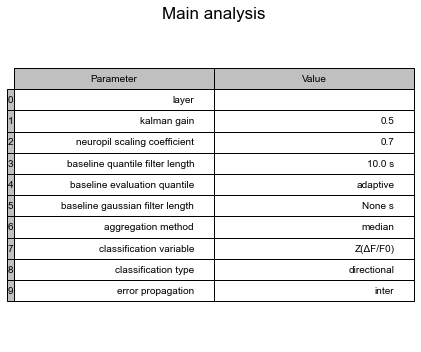

In [5]:
figs['dataset_info'] = plot_table({
    'layer': layer,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'aggregation method': trial_aggfunc.__name__,
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional",
    'error propagation': errprop,
    }, title='Main analysis', aspect=1.5)

### Load data

In [6]:
stats = load_lineagg_stats(input_dir, errprop=errprop)
# Remove PV
if 'pv' in stats.index.unique(Label.LINE):
    stats = stats.drop(labels='pv')
isall = stats.index.get_level_values(Label.ROI_RESP_TYPE) == 'all'
stats_all = stats[isall].droplevel(Label.ROI_RESP_TYPE)
stats_by_rtype = stats[~isall]
stats_pos = stats_by_rtype.loc[pd.IndexSlice[:, 'positive', :]]

 08/06/2023 18:01:15: loading line-average data (with inter-propagated SE) from /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main:
 08/06/2023 18:01:15: repsonder-type-averaged stats successfully loaded for lines line3, sst


### Plot responder type distribution per mouse line

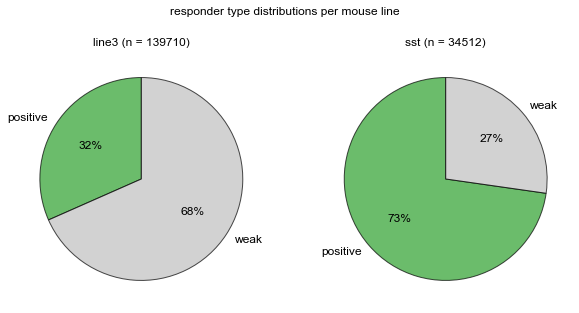

In [7]:
# Plot counts on pie chart
groups = stats_by_rtype.groupby(Label.LINE)
naxes = len(groups)
figs['rtype_dist_per_line'], axes = plt.subplots(1, naxes, figsize=(5 * naxes, 5))
figs['rtype_dist_per_line'].set_facecolor('w')
figs['rtype_dist_per_line'].suptitle('responder type distributions per mouse line')
for ax, (line, gdata) in zip(axes, groups):
    counts_by_rtype = gdata['count'].groupby(Label.ROI_RESP_TYPE).first()
    ax.set_title(f'{line} (n = {counts_by_rtype.sum()})')
    counts_by_rtype.plot.pie(
        ax=ax, ylabel='', autopct='%1.0f%%',
        colors=[Palette.RTYPE[k] for k in counts_by_rtype.index],
        startangle=90, textprops={'fontsize': 12},
        wedgeprops={'edgecolor': 'k', 'alpha': 0.7}
    )

### Plot parameter dependency curves 

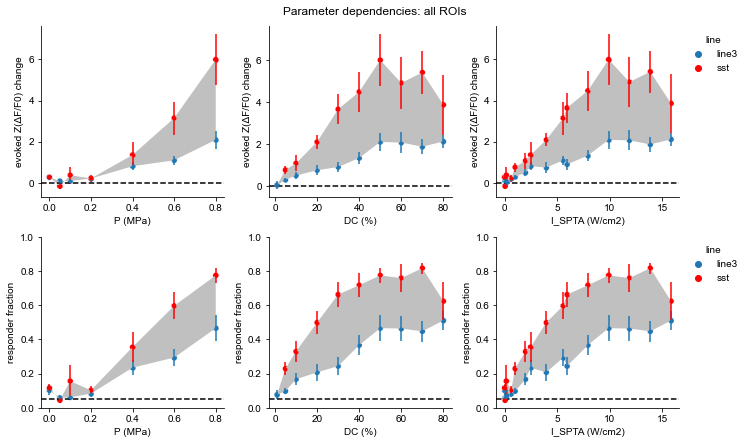

In [8]:
ykeys = [get_change_key(Label.ZSCORE), Label.RESP_FRAC]
for statstype, tmpstats in {
        'all': stats_all, 
        # 'pos': stats_pos
    }.items():
    figs[f'simparams_deps_{statstype}'], axes = plt.subplots(
        len(ykeys), len(xkeys_plt), figsize=(3.5 * len(xkeys_plt), 3 * len(ykeys)))
    for ykey, axrow in zip(ykeys, axes):
        plot_parameter_dependency_across_lines(
            tmpstats.copy(),
            xkeys_plt,
            ykey,
            yref=PTHR_DETECTION if ykey == Label.RESP_FRAC else 0.,
            axes=axrow,
            connect=None,
            err_style='bars',
            fill_between=True,
            # norm=True
        )
    figs[f'simparams_deps_{statstype}'].suptitle(
        f'Parameter dependencies: {statstype} ROIs', y=1.02)
    harmonize_axes_limits(axrow)
    if ykey == Label.RESP_FRAC:
        for ax in axrow:
            ax.set_ylim(0, 1)

### Fit response strength = f(ISPTA)

 08/06/2023 18:06:08: threshold P_SPTA (MPa) = 0.02
 08/06/2023 18:06:08: saturation P_SPTA (MPa) = 0.46
 08/06/2023 18:06:08: best evoked Z(ΔF/F0) change fit = sigmoid(P_SPTA (MPa), 0.24, 0.10, 2.15): R2 = 0.96
 08/06/2023 18:06:08: threshold I_SPTA (W/cm2) = 0.54
 08/06/2023 18:06:08: saturation I_SPTA (W/cm2) = 11.42
 08/06/2023 18:06:08: best evoked Z(ΔF/F0) change fit = sigmoid(I_SPTA (W/cm2), 5.98, 2.48, 2.15): R2 = 0.96
 08/06/2023 18:06:08: threshold P_SPTRMS (MPa) = 0.13
 08/06/2023 18:06:08: saturation P_SPTRMS (MPa) = 0.51
 08/06/2023 18:06:08: best evoked Z(ΔF/F0) change fit = sigmoid(P_SPTRMS (MPa), 0.32, 0.09, 2.41): R2 = 0.95
 08/06/2023 18:06:08: threshold I_SPTRMS (W/cm2) = 4.03
 08/06/2023 18:06:08: saturation I_SPTRMS (W/cm2) = 15.32
 08/06/2023 18:06:08: best evoked Z(ΔF/F0) change fit = sigmoid(I_SPTRMS (W/cm2), 9.74, 2.60, 2.41): R2 = 0.95
 08/06/2023 18:06:08: threshold P_SPTA (MPa) = 0.03
 08/06/2023 18:06:08: saturation P_SPTA (MPa) = 0.31
 08/06/2023 18:06:08:

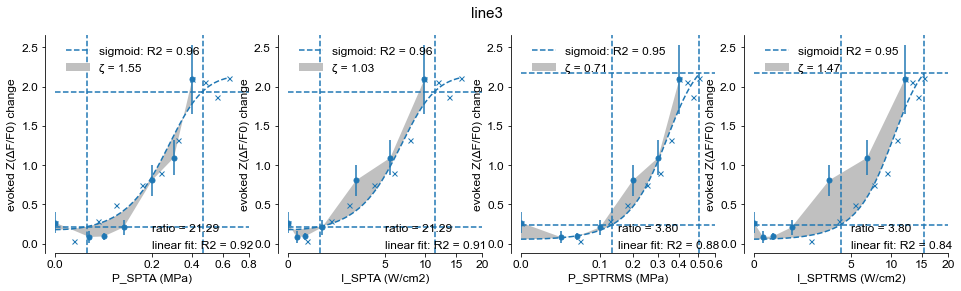

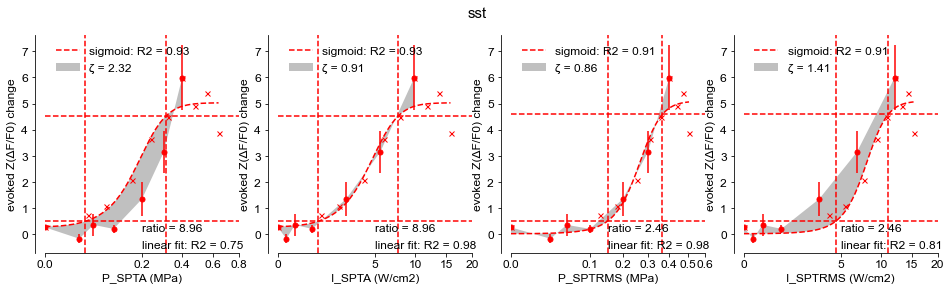

In [16]:
# Independent variables used for fits
fit_xkeys = [
    # Label.P,
    # Label.DC,
    Label.PSPTA, 
    Label.ISPTA, 
    Label.PSPTRMS, 
    Label.ISPTRMS
]

# Dependent variables used for fits
fit_ykeys = [
    get_change_key(Label.ZSCORE)
]

# Candidate fitting functions to predict response strength
fit_candidates = {
    sigmoid: lambda x, y: [x.mean(), np.ptp(x) / 2, y.max()],
    # custom_sigmoid: [1, 1, 1, 1],
    # mysqrt: lambda x, y: [y.max()], #.1],
    # parabolic: lambda x, y: [np.quantile(x, .1), np.quantile(x, .9), y.max() * 10],
    # bilinear: lambda x, y: [x[np.argmax(y)], y.max(), 1, -1],
}

# For each line
for line, gstats in stats_all.groupby(Label.LINE):
    # For each output metrics
    for ykey_diff in fit_ykeys:
        # Find optimal fits to predict response strength, and plot results
        figs[f'{line} {ykey_diff} fits'], _ = plot_response_fit(
            gstats, ykey_diff, fit_candidates, 
            xkey=fit_xkeys, 
            xscale='sqrt', 
            fitsweepkey=Label.DC,
            error_aggfunc='mean',
            height=4,
            # norm=True,
            plot_respmetrics=True,
        )

<AxesSubplot:xlabel='line', ylabel='ratio'>

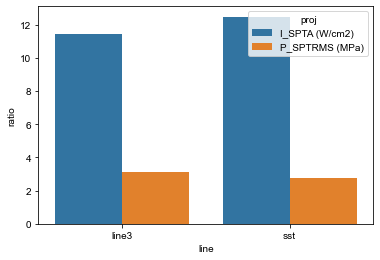

In [39]:
ratios = pd.DataFrame({
    'line': ['line3', 'line3', 'sst', 'sst'],
    'proj': [Label.ISPTA, Label.PSPTRMS, Label.ISPTA, Label.PSPTRMS],
    'ratio': [11.42, 3.13, 12.48, 2.78]
})
sns.barplot(
    data=ratios, x='line', y='ratio', hue='proj'
)

line3
 31/05/2023 18:17:04: best responder fraction fit = sigmoid(I_SPTA (W/cm2), 4.83, 2.99, 0.51): R2 = 0.96
sst
 31/05/2023 18:17:04: best responder fraction fit = sigmoid(I_SPTA (W/cm2), 2.69, 1.58, 0.74): R2 = 0.97


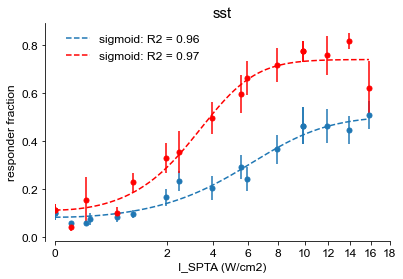

In [47]:
fig, ax = plt.subplots()
# For each line
for line, gstats in stats_all.groupby(Label.LINE):
    print(line)
    # For each output metrics
    for ykey_diff in [Label.RESP_FRAC]: # fit_ykeys:
        # Find optimal fits to predict response strength, and plot results
        figs[f'{line} {ykey_diff} fits'], _ = plot_response_fit(
            gstats, ykey_diff, fit_candidates, 
            xkey=Label.ISPTA, 
            xscale='sqrt', 
            # fitsweepkey=Label.DC,
            # error_aggfunc='median',
            # norm=True,
            ax=ax,
            # plot_respmetrics=True,
        )

### Save figures

In [42]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 31/05/2023 16:56:55: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2023.05.31/figs_main_all_k0.5_alpha0.7_qadaptive_wq10.0s_aggmedian_classzscore_directional_inter.pdf:


100%|██████████| 6/6 [00:00<00:00,  8.12it/s]


### Notify upon completion

In [11]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'main analysis notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 04/05/2023 18:57:30: main analysis notebook completed in 0:00:03.134431 s
